# Train a Smartcab to Drive 

## Implement a Basic Driving Agent

*To begin, your only task is to get the smartcab to move around in the environment. At this point, you will not be concerned with any sort of optimal driving policy. Note that the driving agent is given the following information at each intersection:*

- *The next waypoint location relative to its current location and heading.*
- *The state of the traffic light at the intersection and the presence of oncoming vehicles from other directions.*
- *The current time left from the allotted deadline.*

*To complete this task, simply have your driving agent choose a random action from the set of possible actions (None, 'forward', 'left', 'right') at each intersection, disregarding the input information above. Set the simulation deadline enforcement, enforce_deadline to False and observe how it performs.*

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time

# To display pd.DataFrames beautifully
from IPython.display import display, HTML

# visualization
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline  

# init seaborn
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 1}                  
sns.set_context("paper", font_scale=1.5, rc = paper_rc)
husl_color = sns.color_palette("husl", n_colors=100, desat=0.75)

In [2]:
# # Read data
filename = "random-actions_False_0.0_0.0.csv"
run_mode, enforce_deadline, alpha, gamma = filename.split('_')
enforce_deadline = eval(enforce_deadline)

data = pd.read_csv(filename)
print "Data file read successfully!"

Data file read successfully!


In [3]:
data_columns = ['trial_num', 'step_num', 'deadline', 'traffic_left', 'traffic_right', 'traffic_oncoming', 
                'light', 'next_waypoint', 'action', 'reward']

def print_summary():
    
    num_of_rows = data.shape[0]
    num_of_cols = data.shape[1]
    num_of_trials = len(data['trial_num'].unique())
    
    print "No of Rows: ", num_of_rows
    print "No of Cols: ", num_of_cols
    print "No of Trials: ", num_of_trials
    print "Column Names: ", data.columns.values

print_summary()

No of Rows:  7873
No of Cols:  10
No of Trials:  100
Column Names:  ['action' 'deadline' 'light' 'next_waypoint' 'reward' 'step_num'
 'traffic_left' 'traffic_oncoming' 'traffic_right' 'trial_num']


In [4]:
# let us visualize data. May be we will learn something new

def prepare_data_for_visualization():
    
    allotted_deadlines = {}
    net_rewards = {}
    avg_rewards = {}
    
    gb = data.groupby(['trial_num'])

    trial_nums = data['trial_num'].unique()
    trial_steps_taken = gb.size()
    
    for gb_trial_num in gb.groups:
        trial_num = gb_trial_num
        first_row_index = gb.groups[trial_num][0]
        allotted_deadline = data.ix[first_row_index, ['deadline']][0]
        allotted_deadlines[trial_num] = allotted_deadline
        net_rewards[trial_num] = data[data['trial_num'] == trial_num]['reward'].sum()
        avg_rewards[trial_num] = data[data['trial_num'] == trial_num]['reward'].mean()
        
    return trial_nums, allotted_deadlines, trial_steps_taken, net_rewards, avg_rewards

# separate data into following three subsets - for further groupwise analysis
def slice_data_into_3_groups():
    
    # init variables
    unsuccessful_trials = {}
    successful_trials_beyond_deadline = {}
    successful_trials_within_deadline = {}

    gb = data.groupby(['trial_num'])

    for gb_trial_num in gb.groups:

        trial_num = gb_trial_num
        trial_length = len(gb.groups[trial_num])

        first_row_index = gb.groups[trial_num][0]
        last_row_index = gb.groups[trial_num][-1]

        allotted_deadline = data.ix[first_row_index, ['deadline']][0]
        last_row_deadline = data.ix[last_row_index, ['deadline']][0]
        last_row_reward = data.ix[last_row_index, ['reward']][0]

        if last_row_deadline <= -100:
            unsuccessful_trials[trial_num] = trial_length # Primary agent hit hard time limit
        elif enforce_deadline == True and last_row_deadline <= 0 and not (last_row_reward == 12.0 or last_row_reward == 9.5):
            unsuccessful_trials[trial_num] = trial_length # Primary agent ran out of time
        elif enforce_deadline == False and last_row_deadline <= 0:
            successful_trials_beyond_deadline[trial_num] = trial_length
        else:
            successful_trials_within_deadline[trial_num] = trial_length 

    return unsuccessful_trials, successful_trials_beyond_deadline, successful_trials_within_deadline

def visualize_loaded_data(ax=None, title=None, color=husl_color, increase_ylim_factor=2):

    trial_nums, allotted_deadlines, trial_steps_taken, net_rewards, avg_rewards = prepare_data_for_visualization()
    
    # draw plot 
    if ax == None:
        f, ax = plt.subplots(figsize=(20,5))
        
    ax.bar(trial_nums, trial_steps_taken, color=color)
    ax.plot(trial_nums, allotted_deadlines.values(), label="Deadline", linestyle="-", color='red', linewidth=1)
    ax.plot(trial_nums, net_rewards.values(), label="Net Reward", linestyle="-", color='green', linewidth=1)
    ax.plot(trial_nums, avg_rewards.values(), label="Avg Reward", linestyle="-", color='m', linewidth=1)

    ax.set_xlabel('trial_num')
    ax.set_ylabel('# of steps taken')
    ax.set_xlim(left=1,right=trial_nums.size)
    
    if title:
        ax.set_title(title)
        
        
    unsuccessful_trials, successful_trials_beyond_deadline, successful_trials_within_deadline = slice_data_into_3_groups()

    ax.plot(unsuccessful_trials.keys(), 
            np.repeat(ax.get_ylim()[0]+2, len(unsuccessful_trials)), 
            marker='o', color='red', linestyle='None', markersize=6, label="Failure")
    ax.plot(successful_trials_beyond_deadline.keys(), 
            np.repeat(ax.get_ylim()[0]+2, len(successful_trials_beyond_deadline)), 
            marker='o', color='cornflowerblue', linestyle='None', markersize=6, label="Success (beyond deadline)")
    ax.plot(successful_trials_within_deadline.keys(), 
            np.repeat(ax.get_ylim()[0]+2, len(successful_trials_within_deadline)), 
            marker='o', color='darksage', linestyle='None', markersize=6, label="Success (within deadline)")
    
    y_lim_top = ax.get_ylim()[1] + increase_ylim_factor * (ax.get_yticks(minor=False)[-1] - ax.get_yticks(minor=False)[-2])
    y_lim_bottom = ax.get_ylim()[0]
    if y_lim_bottom == 0:
        y_lim_bottom = y_lim_bottom -  (ax.get_yticks(minor=False)[-1] - ax.get_yticks(minor=False)[-2])
        
    ax.set_ylim(top=y_lim_top, bottom=y_lim_bottom)
    
    ax.legend()
    
    return ax

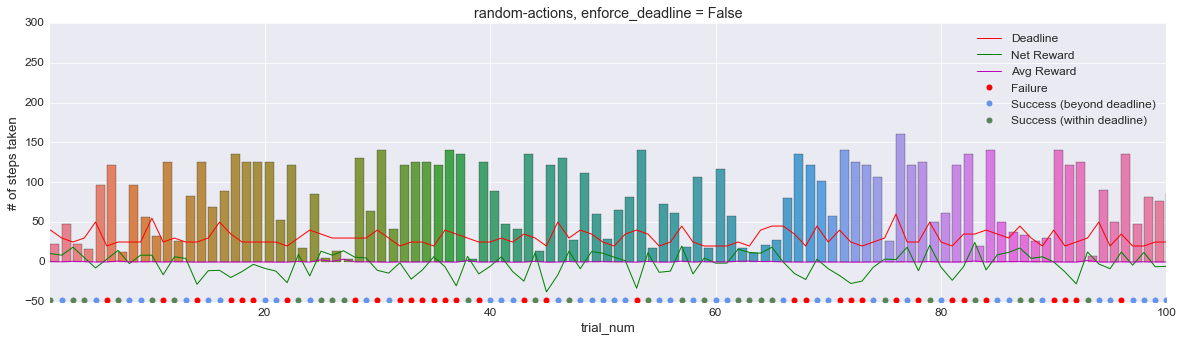

In [5]:
# create plot
title = "{}, enforce_deadline = {}".format(run_mode, enforce_deadline)
_ = visualize_loaded_data(title=title)

*Observations:*

- Lot of trials overshot the allotted deadline.
- By looking at the magnitude of the overshoot, it looks like in lot of trials, smartcab did not reach destination. This segment of data also includes the cases, where smartcab reached destination beyond deadline but within hardlimit of (-100). 
- Only in about 10-15% trials, smartcab reached destination within allotted deadline. (green dots)
- We will have to slice data in various segments to study in detail

In [6]:
# let us investigate Shortest and Longest trials. May be we will learn something from the subsets

# function that finds the shortest and longest trial in the entire loaded data
def find_shortest_longest_trial():
    
    shortest_trial_num = -1
    shortest_trial_size = -1
    longest_trial_num = -1
    longest_trial_size = -1

    gb = data.groupby(['trial_num'])

    shortest_trial_size = sorted(gb.size())[0]
    longest_trial_size = sorted(gb.size(), reverse=True)[0]

    for gb_trial_num in gb.groups:

        if ((shortest_trial_num == -1) and (len(gb.groups[gb_trial_num]) == shortest_trial_size)):
            shortest_trial_num = gb_trial_num

        if ((longest_trial_num == -1) and (len(gb.groups[gb_trial_num]) == longest_trial_size)):
            longest_trial_num = gb_trial_num

        if ((shortest_trial_num != -1) and (longest_trial_num != -1)):
            break
            
    return shortest_trial_num, shortest_trial_size, longest_trial_num, longest_trial_size

# function that displays the dataset table for the given trial_num
def display_trial(trial_num):
    
    trial_set = data[data.trial_num == trial_num][data_columns]
    
    if (len(trial_set) <= 10):
        display(trial_set)
    else:
        display(trial_set.head())
        display(trial_set.tail())

def show_shortest_longest_trial_summary():
    
    shortest_trial_num, shortest_trial_size, longest_trial_num, longest_trial_size = find_shortest_longest_trial()
    
    print "Shortest Trial (#{}) is of length: {}".format(shortest_trial_num, shortest_trial_size)
    print "Longest Trial (#{}) is of length: {}".format(longest_trial_num, longest_trial_size)


In [7]:
# show summary
show_shortest_longest_trial_summary()

Shortest Trial (#27) is of length: 4
Longest Trial (#76) is of length: 161


In [8]:
# extract the shortest_trial subset from the data
shortest_trial_num, _, _, _ = find_shortest_longest_trial()
display_trial(shortest_trial_num)

,trial_num,step_num,deadline,traffic_left,traffic_right,traffic_oncoming,light,next_waypoint,action,reward
1854,27,0,30,None,None,None,red,right,None,0.0
1855,27,1,29,None,None,None,red,right,right,2.0
1856,27,2,28,None,None,None,red,right,None,0.0
1857,27,3,27,None,None,None,red,right,right,12.0


*Findings 1*
    
- In this trial, smartcab made it to the destination within allotted deadline. 
- Considering smartcab is taking random actions (without any Learning, whatsoever) this was a very lucky trial.
- So smartcab does reach the destination sometimes, even in the random (non-learning) case.

In [9]:
# extract the longest_trial subset from the data
_, _, longest_trial_num, _ = find_shortest_longest_trial()
display_trial(longest_trial_num)

,trial_num,step_num,deadline,traffic_left,traffic_right,traffic_oncoming,light,next_waypoint,action,reward
5795,76,0,60,None,None,None,green,left,forward,-0.5
5796,76,1,59,None,None,None,green,left,left,2.0
5797,76,2,58,None,None,None,green,forward,None,0.0
5798,76,3,57,None,None,None,green,forward,right,-0.5
5799,76,4,56,None,None,None,green,left,forward,-0.5


,trial_num,step_num,deadline,traffic_left,traffic_right,traffic_oncoming,light,next_waypoint,action,reward
5951,76,156,-96,None,None,None,red,forward,left,-1.0
5952,76,157,-97,None,None,None,red,forward,forward,-1.0
5953,76,158,-98,None,None,None,red,forward,left,-1.0
5954,76,159,-99,None,None,None,red,forward,left,-1.0
5955,76,160,-100,forward,None,None,green,forward,forward,2.0


*Findings 2*

- In this trial, smartcab did not reach the destination. It hit hard time limit (-100) and trial was aborted. (see 'deadline' column)
- Allotted deadline for the trial is the value of deadline in the first row of the trial subset. 
- When enforce_deadline=False, and if value of (deadline == -100) in the last row of the trial subset, then trial is aborted by the Simulator.
- If the deadline value in the last row were -ve but greater than -100; that means smartcab reached the destination, but beyond its allotted deadline. 
- If the deadline value in the last row were +ve; that means smartcab reached the destination within its allotted deadline.

Armed with these findings (1 & 2), we can now deduce:
- How many trials were unsuccessful (aborted)?
- How many trials were successful within the allotted deadline?
- How many trials were successful beyond the allotted deadline?

**By going through this exercise, my hope is to find a way to measure "goodness" or "scoring" our learning process.**

In [10]:
# generate 5+ point summary of segmented trial data
def gen_trials_summary():
    
    unsuccessful_trials, successful_trials_beyond_deadline, successful_trials_within_deadline = slice_data_into_3_groups()
    
    data_subsets = {
                      'Unsuccessful Trials' : unsuccessful_trials.values(),
                      'Successful beyond deadline' : successful_trials_beyond_deadline.values(),
                      'Successful within deadline' : successful_trials_within_deadline.values()
                   }
    
    stats_rows = []
    
    # calc total of counts of subsets. Used to calculate percentages of each subset
    total_count = sum([len(subset) for subset in data_subsets.values()])
    
    for subset in data_subsets:
        label = subset
        values = data_subsets[label]
        
        _count = len(values) if values else 0
        _min = np.min(values) if values else 0
        _max = np.max(values) if values else 0
        _std = np.std(values) if values else 0
        _mean = np.mean(values) if values else 0
        _proportion = float(_count) / total_count * 100.
        
        d = {
            "Label": label,
            "Count" : _count,
            "Min steps" : _min,
            "Max steps" : _max,
            "Mean" : "{:.2f}".format(_mean),
            "Std" : "{:.2f}".format(_std),
            "Proportion" : "{}%".format(_proportion)
        }
    
        stats_rows.append(pd.Series(d))
       
    
    stats = pd.DataFrame(stats_rows)
    columns = ['Label', 'Count', 'Min steps','Max steps', 'Mean', 'Std', 'Proportion']
    display(stats[columns])
# end def

### Section: Breakdown of results of random-action trials

In [11]:
# summarize run stats
gen_trials_summary()

,Label,Count,Min steps,Max steps,Mean,Std,Proportion
0,Unsuccessful Trials,33,121,161,130.39,9.19,33.0%
1,Successful beyond deadline,41,29,130,74.54,26.62,41.0%
2,Successful within deadline,26,4,50,19.77,10.10,26.0%


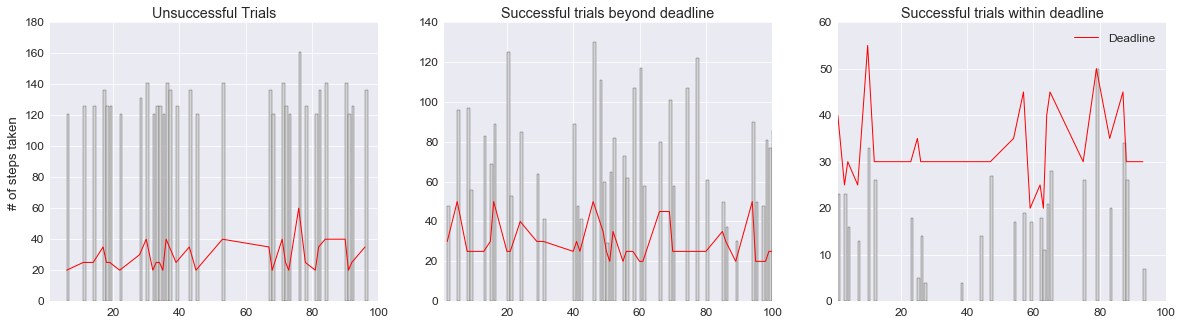

In [12]:
# visulization of 3 segmented trial subsets

unsuccessful_trials, successful_trials_beyond_deadline, successful_trials_within_deadline = slice_data_into_3_groups()
trial_nums, allotted_deadlines, trial_steps_taken, net_rewards, avg_rewards = prepare_data_for_visualization()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# unsuccessful_trials
trial_nums = sorted(unsuccessful_trials.keys())
steps_taken = [unsuccessful_trials[trial_num] for trial_num in trial_nums]
deadlines = [allotted_deadlines[trial_num] for trial_num in trial_nums] 
ax1.bar(trial_nums, steps_taken, color="lightgray")
ax1.plot(trial_nums, deadlines, linestyle="-", color='red', linewidth=1)
ax1.set(xlabel="", ylabel="# of steps taken", title='Unsuccessful Trials')
ax1.set_xlim(left=1,right=100)

# successful_trials_beyond_deadline
trial_nums = sorted(successful_trials_beyond_deadline.keys())
steps_taken = [successful_trials_beyond_deadline[trial_num] for trial_num in trial_nums]
deadlines = [allotted_deadlines[trial_num] for trial_num in trial_nums] 
ax2.bar(trial_nums, steps_taken, color="lightgray")
ax2.plot(trial_nums, deadlines, linestyle="-", color='red', linewidth=1)
ax2.set_xlim(left=1,right=100)
ax2.set(xlabel="", ylabel="", title='Successful trials beyond deadline')

# successful_trials_within_deadline
trial_nums = sorted(successful_trials_within_deadline.keys())
steps_taken = [successful_trials_within_deadline[trial_num] for trial_num in trial_nums]
deadlines = [allotted_deadlines[trial_num] for trial_num in trial_nums] 

ax3.bar(trial_nums, steps_taken, color="lightgray")
ax3.plot(trial_nums, deadlines, label="Deadline", linestyle="-", color='red', linewidth=1)
ax3.set_xlim(left=1,right=100)
ax3.set(xlabel="", ylabel="", title='Successful trials within deadline')
_ = ax3.legend()

**Expectations:**

- After Reinforcement Learning, we expect smartcab to have:
 - Unsuccessful Trials - hardly any
 - Successful trials beyond deadline - none (coz enforce_deadline=True)
 - Successful trials within deadline - maximum
 
This is our first definition of "goodness" of learning process - **Maximum successful trials within deadline. ** So far we have not factored *reward* variable into the definition of "goodness". Once we understand how Environment *rewards* the actions taken by smartcab, we will comeback and improve our "goodness" definition.

Let us now dive into investigating *reward* dynamics...

In [13]:
pd.options.mode.chained_assignment = None  # default='warn'

subset_columns = ['light', 'traffic_left', 'traffic_right', 'traffic_oncoming', 'action', 'next_waypoint', 'reward']
rwd_subset = data[subset_columns]

rewards = sorted(rwd_subset['reward'].unique())
print "Smartcab received these rewards from Environment:", rewards

print "Dataset has {} rows - bit too many to do any useful manual analysis...".format(rwd_subset.shape[0])
rwd_subset.drop_duplicates(inplace = True)
print "After removing duplicates, dataset has {} rows...".format(rwd_subset.shape[0])
print "Sample rows from reduced set for each Rwd ({}) to study Agent-Env rewards dynamics".format(rewards)

Smartcab received these rewards from Environment: [-1.0, -0.5, 0.0, 2.0, 9.5, 12.0]
Dataset has 7873 rows - bit too many to do any useful manual analysis...
After removing duplicates, dataset has 194 rows...
Sample rows from reduced set for each Rwd ([-1.0, -0.5, 0.0, 2.0, 9.5, 12.0]) to study Agent-Env rewards dynamics


In [14]:
def sample_next_rewards_subset(rewards_index = 0):
    tmp = rwd_subset[rwd_subset['reward'] == rewards[rewards_index]]
    display(tmp.head())
    rewards_index = rewards_index + 1
    return rewards_index

rewards_index = sample_next_rewards_subset()

,light,traffic_left,traffic_right,traffic_oncoming,action,next_waypoint,reward
2,red,None,None,None,left,forward,-1.0
8,red,None,None,None,left,left,-1.0
13,red,None,None,None,forward,left,-1.0
31,red,None,None,None,forward,forward,-1.0
56,red,None,None,None,forward,right,-1.0


- Reward = -1 is the lowest reward that the environment assigns to the agent
- Smartcab gets this reward, whenever it breaks traffic rules, such as:
 - Running red light
 - Turning left on red light

In [15]:
rewards_index = sample_next_rewards_subset(rewards_index)

,light,traffic_left,traffic_right,traffic_oncoming,action,next_waypoint,reward
5,green,None,None,None,left,forward,-0.5
6,green,None,None,None,left,right,-0.5
11,red,right,None,None,right,forward,-0.5
12,green,None,None,None,forward,left,-0.5
16,red,None,None,None,right,forward,-0.5


- Smartcab receives Reward = -0.5, whenever
 - it takes legal traffic action (moving on green light and turning right on red light)
 - but deviates from its planned path

In [16]:
rewards_index = sample_next_rewards_subset(rewards_index)

,light,traffic_left,traffic_right,traffic_oncoming,action,next_waypoint,reward
1,red,None,None,None,None,forward,0.0
14,red,None,None,None,None,left,0.0
20,green,None,None,None,None,forward,0.0
24,green,None,None,None,None,left,0.0
41,red,None,None,None,None,right,0.0


- Reward = 0.0 is the neutral reward that environment assigns to the smartcab
- Smartcab receives this reward, whenever it
 - neither breaks any traffic rules
 - nor deviates from its planned path (next waypoint)
 - it simply stays where it is (action = None)
 
This is a very important discovery: **When in doubt; simply stay where you are.** Environment will neither punish nor reward you. I'm sure we will somehow incorporate this discovery in our learning algorithm later.

In [17]:
rewards_index = sample_next_rewards_subset(rewards_index)

,light,traffic_left,traffic_right,traffic_oncoming,action,next_waypoint,reward
0,red,None,None,None,right,right,2.0
9,green,None,None,None,left,left,2.0
36,green,None,None,None,right,right,2.0
69,green,None,None,None,forward,forward,2.0
133,green,None,forward,None,left,left,2.0


- Reward = 2.0 is first +ve Reinforcing Reward
- Smartcab receives this reward, whenever it
 - follows all the traffic rules
 - follows the planned path (action == next waypoint)

In [18]:
rewards_index = sample_next_rewards_subset(rewards_index)

,light,traffic_left,traffic_right,traffic_oncoming,action,next_waypoint,reward
109,green,None,None,None,left,right,9.5
3009,green,None,None,None,forward,right,9.5
4246,red,None,None,None,right,left,9.5


- Reward = 9.5 is kinda rare reward.
- It happens when smartcab accidently reaches destination without following planned path (action != next waypoint)
 - cab gets penalized with Reward = -0.5 for not following planned path
 - then it receives Reward = 10 (Bonus) for reaching the destination
 - Total Reward = -0.5 + 10.0 = 9.5
- I do not think this case will occur after RL training, because after RL cab must follow planned path to the letter. So penalty of -0.5 (action != next waypoint) must not arise. 

In [19]:
rewards_index = sample_next_rewards_subset(rewards_index)

,light,traffic_left,traffic_right,traffic_oncoming,action,next_waypoint,reward
22,green,None,None,None,right,right,12.0
339,green,None,None,None,left,left,12.0
525,green,None,None,None,forward,forward,12.0
1857,red,None,None,None,right,right,12.0


- Reward = 12.0 is the highest reward.
- Smartcab receives this reward, whenever it
 - follows all the traffic rules and follows the planned path (action == next waypoint). Securing Reward = 2.0 (see 2 cells above).
 - aaaaannnnd reaches the destination for additional bonus reward of 10
 - Total Reward = 2.0 + 10.0 = 12.0

**QUESTION 1**

*Observe what you see with the agent's behavior as it takes random actions. Does the smartcab eventually make it to the destination? Are there any other interesting observations to note?*

**Answer:**

1. Even when smartcab took random actions, disregarding the input information, it reached destination. Please refer *Section: Breakdown of results of random-action trials* for details
 
2. There are couple of interesting observations from our analysis in previous cells
 - Environment penalizes smartcab for not following traffic rules (reward = -1.0)
 - Cab gets penalized for not following the planned path (reward = -0.5)
 - Env remains neutral if cab neither breaks any traffic rules, nor deviates from planned path (reward = 0.0). 
 - Agent gets +vely rewarded for following all traffic rules and sticking with the planned path (reward = 2.0).
 - Finally, Smartcab is rewarded a bonus of 10.0 points for reaching the destination. (total reward = 12.0) 

## Inform the Driving Agent

*Now that your driving agent is capable of moving around in the environment, your next task is to identify a set of states that are appropriate for modeling the smartcab and environment. The main source of state variables are the current inputs at the intersection, but not all may require representation. You may choose to explicitly define states, or use some combination of inputs as an implicit state. At each time step, process the inputs and update the agent's current state using the self.state variable. Continue with the simulation deadline enforcement enforce_deadline being set to False, and observe how your driving agent now reports the change in state as the simulation progresses.*

**QUESTION 2**

*What states have you identified that are appropriate for modeling the smartcab and environment? Why do you believe each of these states to be appropriate for this problem?*

**Answer:**

**Goal:** As observed in analysis above, environment rewards the actions taken by smartcab thus,

- +ve reward for following traffic rules. In order to accurately follow traffic rules, we need to keep track of 
 - Traffic *LIGHT* (values = red, green)
 - Traffic on *LEFT* (values = None, Left, Right, Forward) side of the smartcab
 - *ONCOMING* traffic (values = None, Left, Right, Forward) towards smartcab

- get additional bonus reward for reaching the destination. In order to be able to reach destination, we need to keep track of
 - *NEXT_WAYPOINT* (values = Left, Right, Forward) per planned path

So Smartcab *STATE = LIGHT + ONCOMING + LEFT + NEXT_WAYPOINT*

Note: We do not include following two variables into State:

- Traffic on *RIGHT* (values = None, Left, Right, Forward) side of the smartcab DOES NOT matter, because according to US traffic rules, traffic on the right side of the intersection does not matter to you, unless it is taking a U-Turn. In our project's action list, there is no U-Turn. Hence we will not include it in our State.

- Deadline is not needed as it does not help in achieve our goals. The purpose of deadline is to incentivize agent to act fast and achieve its goal efficiently. It should focus more on exploiting q table and very occassionally wander off to explore. This will keep the net reward +ve. That been said, it does not help us directly in our goal of learning traffic rules. Moreover, adding deadline (values ranging from 0-100) will cause size of State to grow by a factor of 100. This is undesired. Hence we will not include Deadline also in our State.


**OPTIONAL**

*How many states in total exist for the smartcab in this environment? Does this number seem reasonable given that the goal of Q-Learning is to learn and make informed decisions about each state? Why or why not?*

**Answer:**

In order to come up with the Total States, we need to consider all combinations of variables involved in our definition of *State*

STATE = LIGHT + ONCOMING + LEFT + NEXT_WAYPOINT

where,

- LIGHT has (values = red, green) : 2 
- Traffic on LEFT has (values = None, Left, Right, Forward) : 4
- ONCOMING traffic has (values = None, Left, Right, Forward) : 4
- NEXT_WAYPOINT has (values = Left, Right, Forward) : 3

Hence, Total Combinations = 2 x 4 x 4 x 3 = 96

96 seems like a very reasonable number. Considering the fact that we eliminated *traffic on RIGHT* with 4 possible values, our Total Combinations has lessened by a factor of 4. I cannot think of any way of reducing total states much lower. Eliminating any of the listed variables will seriously hamper Smartcab's ability to learn traffic rules or reach the destination efficiently. 

## Implement a Q-Learning Driving Agent

*With your driving agent being capable of interpreting the input information and having a mapping of environmental states, your next task is to implement the Q-Learning algorithm for your driving agent to choose the best action at each time step, based on the Q-values for the current state and action. Each action taken by the smartcab will produce a reward which depends on the state of the environment. The Q-Learning driving agent will need to consider these rewards when updating the Q-values. Once implemented, set the simulation deadline enforcement enforce_deadline to True. Run the simulation and observe how the smartcab moves about the environment in each trial.*

In [20]:
# Read data
filename = "basic-q-learning_False_0.1_0.4.csv"
run_mode, enforce_deadline, alpha, gamma = filename.split('_')
enforce_deadline = eval(enforce_deadline)

data = pd.read_csv(filename)
print_summary()

No of Rows:  7017
No of Cols:  10
No of Trials:  100
Column Names:  ['action' 'deadline' 'light' 'next_waypoint' 'reward' 'step_num'
 'traffic_left' 'traffic_oncoming' 'traffic_right' 'trial_num']


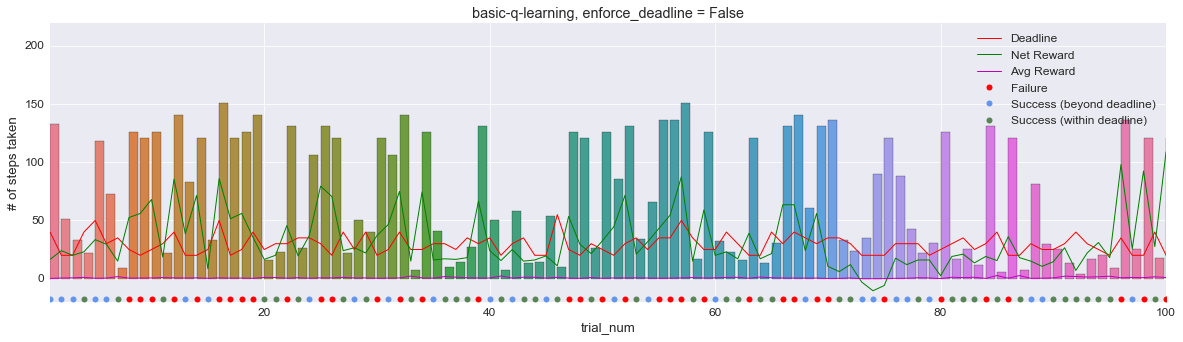

In [21]:
title = "{}, enforce_deadline = {}".format(run_mode, enforce_deadline)
_ = visualize_loaded_data(title=title, increase_ylim_factor=3)

With our very first implementation of Q-Learning, *Net Reward* is almost positive throughout. On the hand, in random-action, *Net Reward* was almost negative. Smartcab is able to reach destination within the allotted deadline more often (green and blue dots). This is amazing! Let us confirm the same in another way... 

In [22]:
gen_trials_summary()

,Label,Count,Min steps,Max steps,Mean,Std,Proportion
0,Unsuccessful Trials,36,121,151,129.61,8.38,36.0%
1,Successful beyond deadline,26,25,133,63.73,29.68,26.0%
2,Successful within deadline,38,4,40,18.26,8.49,38.0%


Uh oh! Success numbers are not significantly better than random-actions. It looks like we have to tune our process.

That been noted, new questions that come to mind are:
- Is this the *optimal* policy for our Smartcab? 
- Is there any other condition (set of parameters), where cab will not only reach the destination within deadline all the time, but also in the most efficient manner?
- Above all - How will we know when a policy is the best? How can we compare multiple policies and draw a conclusion?

## Moment of Epiphany :)

I was just staring at the above graph - thinking to myself...this graph is soo colorful... and pondering above questions... 

That is when it hit me. What if that red zig-zag *Deadline* lineplot was much much farther away from the *Steps Taken* bar plot. What does that mean? What does it mean when Deadline plot overlaps the barplot (as it happened in the random-actions case)? SVM's margin of separation ran through my mind. Bingo!

Drum rolls please! Dun Dun Dunnn ...presenting to you **Deadline Margin Separation Score**.

*Deadline Margin Separation Score* is the difference between *Average Deadline* and *Average Steps Taken*. The greater the difference between the two factors, the better is our policy. Intuitively, this single number Score encapsulates every possible interpretation of the quality of smartcab's q-learning, earning rewards, driving and finally reaching the destination. Mathematically the value of the Score can range from -Inf to +Inf. +ve higher Score is better than -ve lower Score. One Score in isolation is of no use. All else equal, multiple Scores obtained from different episodes of the same experiments can be used to compare episodes to each other. Going forward, we will refer to it as DMS-Score for brevity.

Let us put this newly coined Score to use...

In [23]:
# function to compute DMS-Score
def compute_deadline_margin_separation_score():
    
    trial_nums, allotted_deadlines, trial_steps_taken, net_rewards, avg_rewards = prepare_data_for_visualization()

    # top_y is the highest peak in the plot, where we want to show our annotation tooltip
    top_y = max(max(allotted_deadlines.values()), max(trial_steps_taken))
    
    average_deadline = sum(allotted_deadlines.values()) / float(trial_nums.size)
    average_trial_steps_taken = sum(trial_steps_taken) / float(trial_nums.size)
    deadline_margin_separation_score = average_deadline - average_trial_steps_taken
    
    return deadline_margin_separation_score, average_deadline, average_trial_steps_taken, trial_nums, top_y

# function plots DMS-Score on the graph
def render_deadline_margin_separation_score_lines(ax=None, show_legend=True):
    
    deadline_margin_separation_score, average_deadline, average_trial_steps_taken, trial_nums, top_y = compute_deadline_margin_separation_score()
        
    # Average Deadline - Scoring Line 
    average_deadline = np.array([average_deadline])
    average_deadline = np.repeat(average_deadline, trial_nums.size) 
    ax.plot(trial_nums, average_deadline, label="Average Deadline", linestyle=":", color='blue', linewidth=2)

    # Average Steps Taken - Scoring Line
    average_trial_steps_taken = np.array([average_trial_steps_taken])
    average_trial_steps_taken = np.repeat(average_trial_steps_taken, trial_nums.size) 
    ax.plot(trial_nums, average_trial_steps_taken, label="Average Steps Taken", linestyle=":", color='black', linewidth=2)

    # Annotation
    pointer_x = trial_nums.size / 6
    pointer_y1 = average_deadline[0]
    pointer_y2 = average_trial_steps_taken[0]
    label_x = pointer_x + 10
    label_y = top_y
    
    label = "Deadline Margin Separation Score {:.2f}".format(deadline_margin_separation_score)
    ax.annotate(label, xy=(pointer_x, pointer_y1), xytext=(label_x, label_y),
                arrowprops=dict(facecolor='black', width=0.5, linestyle=':', shrink=0.0))
    ax.annotate(label, xy=(pointer_x, pointer_y2), xytext=(label_x, label_y),
                arrowprops=dict(facecolor='black', width=0.5, linestyle=':',  shrink=0.0))
    
    if show_legend:
        ax.legend()
    else:
        ax.legend_.remove()
        
def render_success_markers(ax=None, show_legend=True):
    
    unsuccessful_trials, successful_trials_beyond_deadline, successful_trials_within_deadline = slice_data_into_3_groups()

    ax.plot(trial_nums, np.repeat(ax.get_ylim()[0]+5, trial_nums.size), marker='o', color=c, markersize=6, label="Success")

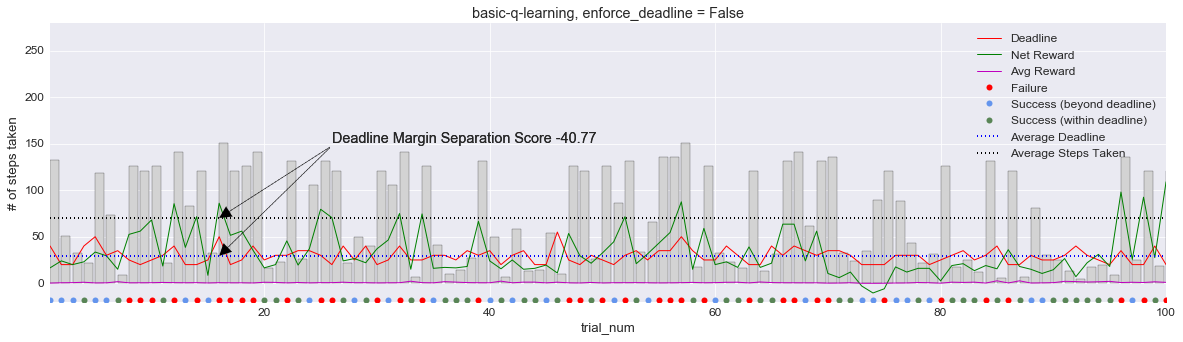

In [24]:
# show DMS-Score on the graph
title = "{}, enforce_deadline = {}".format(run_mode, enforce_deadline)
ax = visualize_loaded_data(color='lightgray', increase_ylim_factor=6, title=title)
render_deadline_margin_separation_score_lines(ax)

This is the same plot as previous one with DMS-Score lines and Score Annotation. I have grayed out the unnecessary parts of the plot to keep the focus on the most important pieces - Score Lines and Score Annotation.

Let us now continue our Data Exploration in different ways. May be we will discovery something else new..

In [25]:
show_shortest_longest_trial_summary()

Shortest Trial (#92) is of length: 4
Longest Trial (#16) is of length: 151


**QUESTION 3** 

*What changes do you notice in the agent's behavior when compared to the basic driving agent when random actions were always taken? Why is this behavior occurring?*

**Answer:**

- After RL, agent has quickly learnt the traffic rules and is able to exploit this information. Coupled with adhering to the planned path agent is reaching the destination more often. Net Reward is positive most of the time - meaning agent is committing less mistakes on its journey. On the other hand, with random-actions, agent reaching the destination was a hit or miss. Even when it somehow made it to destination, it was not without lot of penalties. Unlike now, agent was not learning from its mistakes then. 

- This improvement in efficient navigation and maximization of rewards is occuring because of RL. With RL, agent has quickly learnt from its mistakes and has figured out that in order to maximize its long-term reward it has to:
 - Not break traffic rules and
 - Follow the planned path 

Clearly, RL's reward-punishment mechanism works!


## Improve the Q-Learning Driving Agent

*Your final task for this project is to enhance your driving agent so that, after sufficient training, the smartcab is able to reach the destination within the allotted time safely and efficiently. Parameters in the Q-Learning algorithm, such as the learning rate (alpha), the discount factor (gamma) and the exploration rate (epsilon) all contribute to the driving agent’s ability to learn the best action for each state. To improve on the success of your smartcab:*

- *Set the number of trials, n_trials, in the simulation to 100.*
- *Run the simulation with the deadline enforcement enforce_deadline set to True (you will need to reduce the update delay update_delay and set the display to False).*
- *Observe the driving agent’s learning and smartcab’s success rate, particularly during the later trials.*
- *Adjust one or several of the above parameters and iterate this process.*

*This task is complete once you have arrived at what you determine is the best combination of parameters required for your driving agent to learn successfully.*

In [26]:
# agent.py has produced many *.csv files for various combinations of alpha and gamma.
# load *.csv files, analyze and find out which alpha/gamma combination flared the best.

import os

def load_and_analyze_csv_files():
    
    global data
    global enforce_deadline
    
    rows = [] # for reports

    for file in os.listdir("."):
        if file.endswith(".csv"):
            
            # load data
            data = pd.read_csv(file)

            # computed score
            deadline_margin_separation_score, _, _, _, _ = compute_deadline_margin_separation_score()

            # collect scores for reporting
            basename = os.path.splitext(os.path.basename(file))[0]
            run_mode, enforce_deadline, alpha, gamma = basename.split('_')
            enforce_deadline = eval(enforce_deadline)

            # slice data into 3 groups
            unsuccessful_trials, successful_trials_beyond_deadline, successful_trials_within_deadline = slice_data_into_3_groups()

            d = {
                'file' : file,
                'run_mode': run_mode,
                'enforce_deadline' : enforce_deadline,
                'failure' : len(unsuccessful_trials),
                'success (beyond deadline)': len(successful_trials_beyond_deadline),
                'success (within deadline)' : len(successful_trials_within_deadline),
                'alpha': alpha,
                'gamma' : gamma,
                'score' : float("{:.4f}".format(deadline_margin_separation_score))
                }

            rows.append(pd.Series(d))
    
    return rows

In [27]:
# generate alpha_gamma_analysis_report
rows = load_and_analyze_csv_files()
    
report_data = pd.DataFrame(rows)
report_data.sort_values(["score"], ascending = False, inplace = True)
display(report_data[['run_mode', 'enforce_deadline', 'failure', 'success (beyond deadline)', 'success (within deadline)',
                     'alpha', 'gamma', 'score']])

,run_mode,enforce_deadline,failure,success (beyond deadline),success (within deadline),alpha,gamma,score
19,tuned-q-learning,True,5,0,95,0.3,0.98,12.95
23,tuned-q-learning,True,29,0,71,0.5,0.7,10.59
11,tuned-q-learning,True,26,0,74,0.1,0.7,9.69
35,tuned-q-learning,True,38,0,62,0.9,0.7,9.41
14,tuned-q-learning,True,47,0,53,0.3,0.1,8.31
29,tuned-q-learning,True,45,0,55,0.7,0.7,7.29
4,tuned-q-learning,True,36,0,64,0.01,0.5,7.20
28,tuned-q-learning,True,44,0,56,0.7,0.5,6.94
37,tuned-q-learning,True,48,0,52,0.9,0.98,6.67
13,tuned-q-learning,True,46,0,54,0.1,0.98,6.64


### Section: Alpha Gamma Analysis Report
We conducted q-learning tuning excercise in three modes with various combinations of parameters as listed below 
<pre>
parameters = {
    'random-actions'  :{ 'enforce_deadline':False,
                         'alphas':[0.0],
                         'gammas':[0.0] },
    'basic-q-learning':{ 'enforce_deadline':False, 
                         'alphas':[0.1],
                         'gammas':[0.5] },
    'tuned-q-learning':{ 'enforce_deadline':True, 
                         'alphas':[0.01, 0.1, 0.3, 0.5, 0.7, 0.9],
                         'gammas':[0.1, 0.3, 0.5, 0.7, 0.9, 0.98] }
}
</pre>

*Observation:*

- Above results are sorted by Score for easy review.
- As expected, random-actions mode has the lowest Score and is at the bottom of the table
- The best Scoring combination of parameters is at the top of the table

*Conclusion:*

- After ignoring Worst Case, we can clearly see a range of Scores. So we can conclude that tuning parameters makes a big difference. We must tune parameters well in RL.

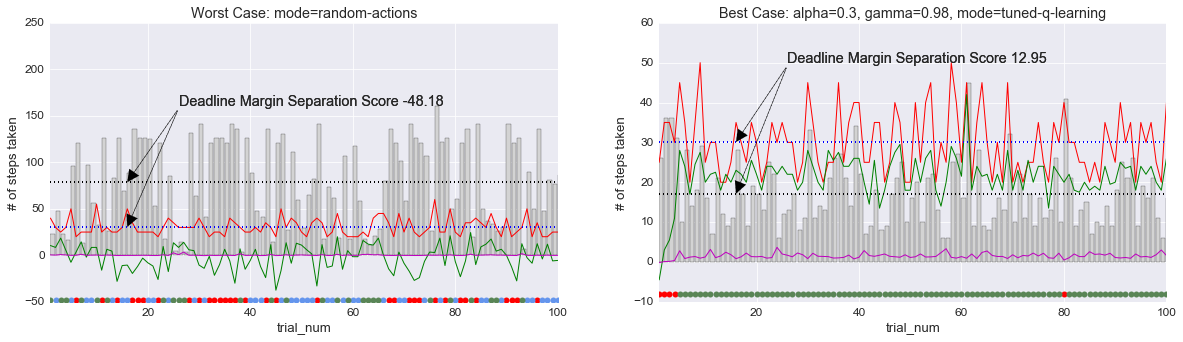

In [28]:
# plot Best & Worst cases side by side for comparitive study

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

# Worst Case
f, alpha, gamma, score, run_mode, enforce_deadline = report_data.iloc[-1][[ 'file', 'alpha', 'gamma', 'score', 'run_mode', 'enforce_deadline']]

# load data & visualize
data = pd.read_csv(f)
title = "Worst Case: mode={}".format(run_mode)
visualize_loaded_data(ax=ax1, title=title, color='lightgray', increase_ylim_factor=1)
render_deadline_margin_separation_score_lines(ax=ax1, show_legend=False)

# Best Case
f, alpha, gamma, score, run_mode, enforce_deadline = report_data.iloc[0][[ 'file', 'alpha', 'gamma', 'score', 'run_mode', 'enforce_deadline']]

# load data & visualize
data = pd.read_csv(f)
title = "Best Case: alpha={}, gamma={}, mode={}".format(alpha, gamma, run_mode)
visualize_loaded_data(ax=ax2, title=title, color='lightgray', increase_ylim_factor=1)
render_deadline_margin_separation_score_lines(ax=ax2, show_legend=False)

Worst & Best cases plotted side by side for your viewing pleasure. We can conclude that discovery and formalizing of *Deadline Margin Separation Score* made a big difference in our analysis. A single Score is very useful in comparitive studies, without which it is very hard to pick a winner.

**QUESTION 4**

*Report the different values for the parameters tuned in your basic implementation of Q-Learning. For which set of parameters does the agent perform best? How well does the final driving agent perform?*

**Answer:**

Please refer to section *Alpha Gamma Analysis Report* above for details. 

The set of parameters that gave the best performance is at the top of the table. I'm not quoting any numbers from the table here because numbers can vary if we re-run the test. If that happens, best score will always appear at the top of the Alpha-Gamma-Analysis report table.

Driving agent is performing pretty well. It has learnt to follow traffic rules. It follows planned path (next waypoint) step by step. Both manifesting as +ve Net Reward curve. 

Smartcab gets -ve rewards for breaking traffic rules. Due to the random nature of the Simulator, learning opportunity can present itself anytime. For example: Near Trial-80, it looks like environment presented few brand new cases, that cab had not learnt from before. Whenever opportunity presents, agent learns from its experience, and exploits it in future.

**QUESTION 5**

*Does your agent get close to finding an optimal policy, i.e. reach the destination in the minimum possible time, and not incur any penalties? How would you describe an optimal policy for this problem?*

**Answer:**

I think my smartcab is pretty close to optimal policy. It is just not feasible to learn the optimal policy in 100 trials. Tuning parameters (alpha, gamma & epsilon) has helped a lot. Given the fact that Net Reward is +ve throughout, and (enforce_deadline = True) - means our smartcab is reaching destination within allocatted deadline. Formalization of *Deadline Margin Separation Score* metrics has also helped greatly. Without it picking a winner would have been impossible.

Optimal Policy is one that maximizes the longterm total reward of the agent. My guess is we can achive that policy if we somehow just follow the next_waypoint. That would bring the smartcab to the destination in the least number of steps with maximum Net Reward. However, in limited (100) trials that is not possible. We have to allow for *Exploration*, so as to learn the traffic rules. With all that been said, I'm pretty confident with the performance of my smartcab. It gotta be sooo close to optimal policy.

**Final Note**

Must Read: [Reinforcement Learning: An Introduction. By: Richard S. Sutton and Andrew G. Barto](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/the-book.html)